<a href="https://colab.research.google.com/github/Bosy-Ayman/Machine_Learning/blob/main/NLP_Assig1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets evaluate accelerate bitsandbytes peft -q


In [ ]:
import os, time, torch, random
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType


In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = "cpu"
print("Using device:", device)

Using device: cpu


# Load the Model and Tokenizer

In [ ]:
model_name = "distilgpt2"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForCausalLM.from_pretrained(model_name).to(device)


In [ ]:

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))
with torch.no_grad():
    model.transformer.wte.weight[tokenizer.pad_token_id].zero_()


#  Load 100 samples


In [ ]:
wiki100 = load_dataset("wikitext","wikitext-2-raw-v1",split="test").select(range(100))
gsm100  = load_dataset("gsm8k","main",split="test").select(range(100))


# Tokenize the Datase

In [ ]:
def tok_w(b): return tokenizer(b["text"],     truncation=True,padding="max_length",max_length=128)
def tok_g(b): return tokenizer(b["question"], truncation=True,padding="max_length",max_length=128)
wiki100 = wiki100.map(tok_w, batched=True)
gsm100  = gsm100.map(tok_g, batched=True)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# Measure Throughput Function

In [ ]:
def measure(ds, m, bs=8):
    m.eval(); tot, t=0,0.0
    with torch.no_grad():
        for i in range(0,len(ds),bs):
            inp = torch.tensor(ds[i:i+bs]["input_ids"],dtype=torch.long).to(device)
            s=time.time(); _=m(inp); e=time.time()
            tot+=inp.numel(); t+=e-s
    return tot/t


In [ ]:
ow,og = measure(wiki100, model), measure(gsm100, model)
print(f"Original → WikiText: {ow:.1f} tok/s, GSM8K: {og:.1f} tok/s")

Original → WikiText: 232.2 tok/s, GSM8K: 267.2 tok/s


In [ ]:
try:
    infer_model = torch.compile(model)
    print(" torch.compile inference model")
except:
    infer_model = model
cw,cg = measure(wiki100, infer_model), measure(gsm100, infer_model)
print(f"Compiled → WikiText: {cw:.1f} tok/s, GSM8K: {cg:.1f} tok/s")


 torch.compile inference model
Compiled → WikiText: 224.4 tok/s, GSM8K: 284.4 tok/s


# Prepare 10 sample train set with labels


In [ ]:
trin_ds = wiki100.select(range(10)).map(lambda b: {"labels": b["input_ids"]}, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
peft_cfg = LoraConfig(task_type=TaskType.CAUSAL_LM,inference_mode=False,
                     r=8,lora_alpha=32,lora_dropout=0.1)
model_lora = get_peft_model(model, peft_cfg)

train_args = TrainingArguments(output_dir="./lora",per_device_train_batch_size=8,
                                num_train_epochs=1,logging_steps=10,report_to="none",
                                label_names=["labels"])
trainer = Trainer(model=model_lora,args=train_args,train_dataset=train_ds)
print("Starting LoRA fine-tuning…")
trainer.train()


Starting LoRA fine-tuning…


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=2, training_loss=15.957096099853516, metrics={'train_runtime': 50.0615, 'train_samples_per_second': 0.2, 'train_steps_per_second': 0.04, 'total_flos': 327753400320.0, 'train_loss': 15.957096099853516, 'epoch': 1.0})

In [ ]:
fw,fg = measure(wiki100, model_lora), measure(gsm100, model_lora)
print(f"Fine-tuned → WikiText: {fw:.1f} tok/s, GSM8K: {fg:.1f} tok/s")


Fine-tuned → WikiText: 274.0 tok/s, GSM8K: 279.9 tok/s


In [ ]:
throughput = {
    "Original WikiText": ow,
    "Original GSM8K": og,
    "Compiled WikiText": cw,
    "Compiled GSM8K": cg,
    "Fine-tuned WikiText": fw,
    "Fine-tuned GSM8K": fg,
}

#  bar plot to compare throughput


Throughput is compared across three versions of the model: Original, Optimized , and Fine-tuned.

In [ ]:


datasets = ['WikiText', 'GSM8K']
original_throughput = [ow, og]
compiled_throughput = [cw, cg]
fine_tuned_throughput = [fw, fg]


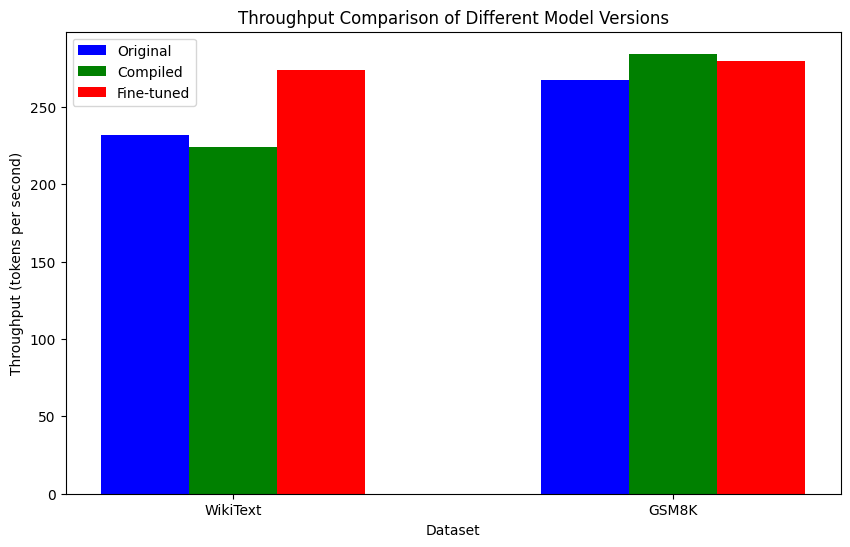

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2
x = range(len(datasets))

ax.bar(x, original_throughput, width, label='Original', color='blue')
ax.bar([p + width for p in x], compiled_throughput, width, label='Compiled', color='green')
ax.bar([p + width * 2 for p in x], fine_tuned_throughput, width, label='Fine-tuned', color='red')

ax.set_xlabel('Dataset')
ax.set_ylabel('Throughput (tokens per second)')
ax.set_title('Throughput Comparison of Different Model Versions')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(datasets)
ax.legend()

plt.show()


**Hardware Requirements:**

**Device:**use GPU for faster processing.